# Statistical Learning and Deep Learning, Fall 2024 HW3
B11705009 An-Che, Liang

In [1]:
!wget http://www.im.ntu.edu.tw/~lu/data/sldl2024/food101_hwds.tgz

--2024-12-05 02:53:59--  http://www.im.ntu.edu.tw/~lu/data/sldl2024/food101_hwds.tgz
Resolving www.im.ntu.edu.tw (www.im.ntu.edu.tw)... 140.112.106.2
Connecting to www.im.ntu.edu.tw (www.im.ntu.edu.tw)|140.112.106.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996214086 (4.7G) [application/x-gzip]
Saving to: ‘food101_hwds.tgz’

food101_hwds.tgz    100%[===================>]   4.65G  15.5MB/s    in 5m 12s  

2024-12-05 02:59:12 (15.3 MB/s) - ‘food101_hwds.tgz’ saved [4996214086/4996214086]



In [2]:
!tar zxvf food101_hwds.tgz

串流輸出內容已截斷至最後 5000 行。
food101/food-101/images/cannoli/695879.jpg
food101/food-101/images/cannoli/1767088.jpg
food101/food-101/images/cannoli/3201965.jpg
food101/food-101/images/cannoli/3778102.jpg
food101/food-101/images/cannoli/2674065.jpg
food101/food-101/images/cannoli/1169899.jpg
food101/food-101/images/cannoli/1378086.jpg
food101/food-101/images/cannoli/803909.jpg
food101/food-101/images/cannoli/1067240.jpg
food101/food-101/images/cannoli/3002709.jpg
food101/food-101/images/cannoli/2612632.jpg
food101/food-101/images/cannoli/3627612.jpg
food101/food-101/images/cannoli/1798703.jpg
food101/food-101/images/cannoli/560632.jpg
food101/food-101/images/cannoli/512468.jpg
food101/food-101/images/cannoli/2331523.jpg
food101/food-101/images/cannoli/3118302.jpg
food101/food-101/images/cannoli/1499412.jpg
food101/food-101/images/cannoli/1557459.jpg
food101/food-101/images/cannoli/146566.jpg
food101/food-101/images/cannoli/96922.jpg
food101/food-101/images/cannoli/1699562.jpg
food101/food-101/i

## Part1: Resnet as a Feature Extractor, after FC Layer

In [ ]:
import torch
import torchvision
from torchvision import models, transforms, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

In [ ]:
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

valid_tfms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
])

batch_size = 196

trainset = torchvision.datasets.Food101(root='./food101', split="train", download=False, transform=valid_tfms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=6)

validset = torchvision.datasets.Food101(root='./food101', split="test", download=False, transform=valid_tfms)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=6)

assert trainset.classes == validset.classes
classes = trainset.classes
num_classes = len(classes)

print("Number of classes =", num_classes)

Number of classes = 101


In [ ]:
device = torch.device("mps")
resnet50 = models.resnet50(weights="IMAGENET1K_V2")
resnet50.fc = torch.nn.Identity()  # Replace the fully connected layer with an identity layer
resnet50 = resnet50.to(device)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def extract_features(dataloader, model):
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            outputs = model(images)  # Extract 1000-dimensional features
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

In [ ]:
train_features, train_labels = extract_features(trainloader, resnet50)
test_features, test_labels = extract_features(validloader, resnet50)


Extracting Features: 100%|██████████| 129/129 [06:17<00:00,  2.92s/it]


In [ ]:
logreg = LogisticRegression(max_iter=1000, verbose=1, n_jobs=-1)
logreg.fit(train_features, train_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       206949     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61512D+00    |proj g|=  4.86234D-02


 This problem is unconstrained.



At iterate   50    f=  1.27395D+00    |proj g|=  7.07186D-03

At iterate  100    f=  9.93092D-01    |proj g|=  9.82457D-03

At iterate  150    f=  8.90531D-01    |proj g|=  3.46589D-03

At iterate  200    f=  8.52607D-01    |proj g|=  9.07444D-04

At iterate  250    f=  8.38238D-01    |proj g|=  6.39770D-04

At iterate  300    f=  8.32456D-01    |proj g|=  4.41992D-04

At iterate  350    f=  8.30074D-01    |proj g|=  1.98946D-04

At iterate  400    f=  8.29195D-01    |proj g|=  1.66219D-04

At iterate  450    f=  8.28829D-01    |proj g|=  8.90317D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    450    456   

LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1)

In [ ]:
test_predictions = logreg.predict(test_features)
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 60.64%


## Part2: Resnet as a Feature Extractor, before FC Layer

In [ ]:
resnet50.fc = torch.nn.Identity()  # Remove the final fc layer
resnet50 = resnet50.to(device)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
train_features_2048, train_labels_2048 = extract_features(trainloader, resnet50)
test_features_2048, test_labels_2048 = extract_features(validloader, resnet50)


Extracting Features: 100%|██████████| 129/129 [05:11<00:00,  2.42s/it]


In [ ]:
logreg_2048 = LogisticRegression(max_iter=1000, verbose=1, n_jobs=-1)
logreg_2048.fit(train_features_2048, train_labels_2048)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       206949     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61512D+00    |proj g|=  4.86234D-02


 This problem is unconstrained.



At iterate   50    f=  1.27395D+00    |proj g|=  7.07186D-03

At iterate  100    f=  9.93092D-01    |proj g|=  9.82449D-03

At iterate  150    f=  8.90532D-01    |proj g|=  3.47315D-03

At iterate  200    f=  8.52266D-01    |proj g|=  1.13297D-03

At iterate  250    f=  8.38093D-01    |proj g|=  1.29713D-03

At iterate  300    f=  8.32523D-01    |proj g|=  1.29053D-03

At iterate  350    f=  8.30143D-01    |proj g|=  2.18735D-04

At iterate  400    f=  8.29217D-01    |proj g|=  3.16976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    422    428      1     0     0   9.763D-05   8.290D-01
  F =  0.828995947872

LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1)

In [ ]:
test_predictions_2048 = logreg_2048.predict(test_features_2048)
accuracy_2048 = accuracy_score(test_labels_2048, test_predictions_2048)
print(f"Test Accuracy using 2048 features: {accuracy_2048 * 100:.2f}%")

Test Accuracy using 2048 features: 60.58%


We can observe that the two approaches yield virtually no difference. The 1000-feature representation achieves an accuracy of 60.64%, while the 2048-feature representation achieves 60.58%. This similarity arises because most of the feature extraction is performed within the residual blocks. As a result, including or excluding the final fully connected (FC) layer has minimal impact on performance.

## Part3: Resnet Finetuning

In [8]:
from torchvision import transforms
import torch
import torchvision

# data transformation during training
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# data transformation during validation
valid_tfms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the training and validation datasets
trainset = torchvision.datasets.Food101(root='./food101', split="train", download=False, transform=train_tfms)
validset = torchvision.datasets.Food101(root='./food101', split="test", download=False, transform=valid_tfms)

batch_size = 368

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=6)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=6)

num_classes = len(trainset.classes)
print(f"Number of classes: {num_classes}")


Number of classes: 101


In [9]:
import torch.nn as nn
from torchvision import models

# load the pre-trained ResNet-50 model
resnet50 = models.resnet50(weights="IMAGENET1K_V2")
resnet50.fc = nn.Linear(2048, num_classes)  # 替換最後一層

# set the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

In [10]:
optimizer = torch.optim.Adam(resnet50.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [13]:
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm


def train_and_evaluate(
    model,
    trainloader,
    validloader,
    optimizer,
    criterion,
    scheduler,
    num_epochs=20,
    patience=5,
):
    best_val_f1 = 0
    patience_counter = 0
    train_losses, val_losses, val_accuracies, val_f1s = [], [], [], []

    for epoch in range(num_epochs):
        # 訓練階段
        model.train()
        running_loss = 0
        for inputs, targets in tqdm(trainloader, desc="Epoch {}".format(epoch + 1)):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(trainloader))

        # 驗證階段
        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for inputs, targets in validloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        val_losses.append(val_loss / len(validloader))
        val_acc = np.mean(np.array(all_preds) == np.array(all_targets))
        val_f1 = f1_score(all_targets, all_preds, average="macro")

        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        print(
            f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, "
            f"Val Acc = {val_acc:.4f}, Val Macro F1 = {val_f1:.4f}"
        )

        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step(val_loss)

    return train_losses, val_losses, val_accuracies, val_f1s

In [14]:
train_losses_all, val_losses_all, val_accs_all, val_f1s_all = train_and_evaluate(
    resnet50, trainloader, validloader, optimizer, criterion, scheduler
)

Epoch 1: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 1: Train Loss = 1.4282, Val Loss = 1.2406, Val Acc = 0.6762, Val Macro F1 = 0.6750


Epoch 2: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 2: Train Loss = 1.1237, Val Loss = 1.0625, Val Acc = 0.7144, Val Macro F1 = 0.7142


Epoch 3: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 3: Train Loss = 0.9700, Val Loss = 0.9783, Val Acc = 0.7353, Val Macro F1 = 0.7352


Epoch 4: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 4: Train Loss = 0.8737, Val Loss = 0.9439, Val Acc = 0.7443, Val Macro F1 = 0.7455


Epoch 5: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 5: Train Loss = 0.8003, Val Loss = 0.8745, Val Acc = 0.7611, Val Macro F1 = 0.7605


Epoch 6: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 6: Train Loss = 0.7318, Val Loss = 0.8608, Val Acc = 0.7661, Val Macro F1 = 0.7648


Epoch 7: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 7: Train Loss = 0.6833, Val Loss = 0.8387, Val Acc = 0.7713, Val Macro F1 = 0.7705


Epoch 8: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 8: Train Loss = 0.6399, Val Loss = 0.8312, Val Acc = 0.7720, Val Macro F1 = 0.7727


Epoch 9: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 9: Train Loss = 0.6005, Val Loss = 0.8452, Val Acc = 0.7694, Val Macro F1 = 0.7699


Epoch 10: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 10: Train Loss = 0.5658, Val Loss = 0.8278, Val Acc = 0.7762, Val Macro F1 = 0.7768


Epoch 11: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 11: Train Loss = 0.5349, Val Loss = 0.8292, Val Acc = 0.7754, Val Macro F1 = 0.7764


Epoch 12: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 12: Train Loss = 0.5129, Val Loss = 0.8076, Val Acc = 0.7804, Val Macro F1 = 0.7804


Epoch 13: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 13: Train Loss = 0.4870, Val Loss = 0.7999, Val Acc = 0.7850, Val Macro F1 = 0.7842


Epoch 14: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 14: Train Loss = 0.4631, Val Loss = 0.8046, Val Acc = 0.7804, Val Macro F1 = 0.7818


Epoch 15: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 15: Train Loss = 0.4426, Val Loss = 0.8081, Val Acc = 0.7798, Val Macro F1 = 0.7804


Epoch 16: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 16: Train Loss = 0.4227, Val Loss = 0.7932, Val Acc = 0.7854, Val Macro F1 = 0.7852


Epoch 17: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 17: Train Loss = 0.4102, Val Loss = 0.8025, Val Acc = 0.7844, Val Macro F1 = 0.7845


Epoch 18: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 18: Train Loss = 0.3978, Val Loss = 0.7980, Val Acc = 0.7868, Val Macro F1 = 0.7864


Epoch 19: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 19: Train Loss = 0.3745, Val Loss = 0.8089, Val Acc = 0.7848, Val Macro F1 = 0.7855


Epoch 20: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 20: Train Loss = 0.3701, Val Loss = 0.8177, Val Acc = 0.7855, Val Macro F1 = 0.7858


In [15]:
# load the pre-trained ResNet-50 model
resnet50 = models.resnet50(weights="IMAGENET1K_V2")
resnet50.fc = nn.Linear(2048, num_classes)  # 替換最後一層

# set the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# only finetune the final layer
for param in resnet50.parameters():
    param.requires_grad = False  # 凍結所有參數
resnet50.fc.weight.requires_grad = True
resnet50.fc.bias.requires_grad = True

In [15]:
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [18]:
train_losses_fc, val_losses_fc, val_accs_fc, val_f1s_fc = train_and_evaluate(
    resnet50, trainloader, validloader, optimizer, criterion, scheduler, num_epochs=10
)

Epoch 1: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 1: Train Loss = 4.6265, Val Loss = 4.6271, Val Acc = 0.0098, Val Macro F1 = 0.0063


Epoch 2: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 2: Train Loss = 4.6266, Val Loss = 4.6271, Val Acc = 0.0102, Val Macro F1 = 0.0067


Epoch 3: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 3: Train Loss = 4.6267, Val Loss = 4.6272, Val Acc = 0.0097, Val Macro F1 = 0.0063


Epoch 4: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 4: Train Loss = 4.6267, Val Loss = 4.6276, Val Acc = 0.0097, Val Macro F1 = 0.0063


Epoch 5: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 5: Train Loss = 4.6269, Val Loss = 4.6274, Val Acc = 0.0099, Val Macro F1 = 0.0065


Epoch 6: 100%|██████████| 206/206 [01:46<00:00,  1.93it/s]


Epoch 6: Train Loss = 4.6263, Val Loss = 4.6270, Val Acc = 0.0100, Val Macro F1 = 0.0065


Epoch 7: 100%|██████████| 206/206 [01:47<00:00,  1.92it/s]


Epoch 7: Train Loss = 4.6263, Val Loss = 4.6271, Val Acc = 0.0098, Val Macro F1 = 0.0064
Early stopping triggered.


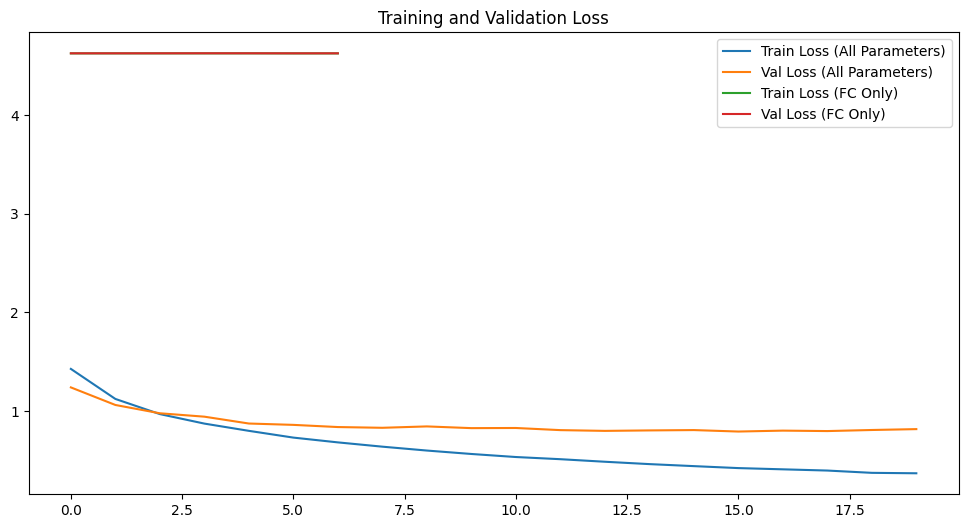

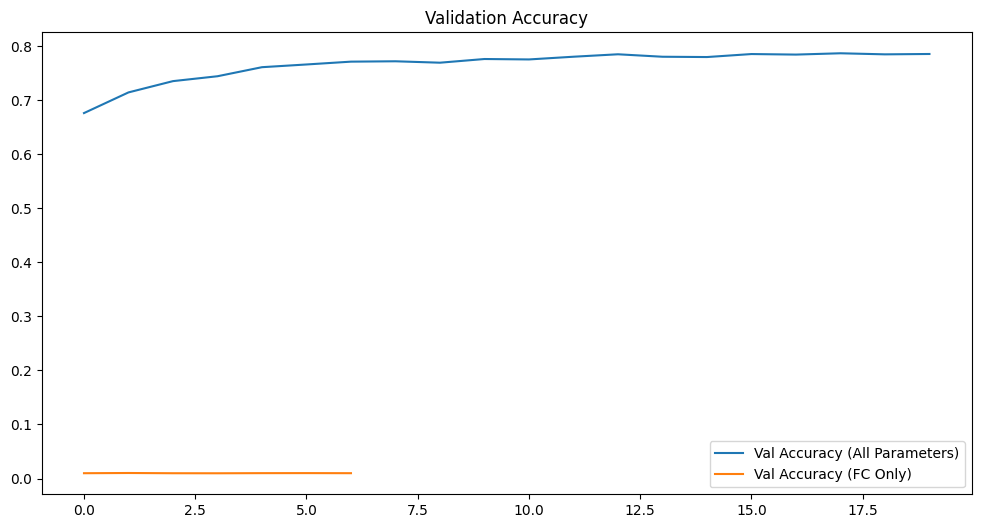

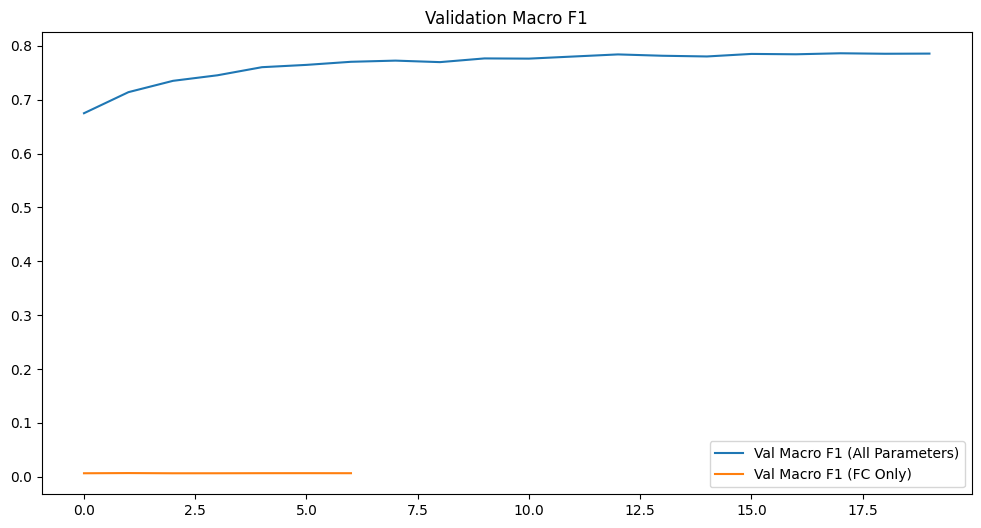

In [19]:
import matplotlib.pyplot as plt

# Loss graph
plt.figure(figsize=(12, 6))
plt.plot(train_losses_all, label="Train Loss (All Parameters)")
plt.plot(val_losses_all, label="Val Loss (All Parameters)")
plt.plot(train_losses_fc, label="Train Loss (FC Only)")
plt.plot(val_losses_fc, label="Val Loss (FC Only)")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Accuracy graph
plt.figure(figsize=(12, 6))
plt.plot(val_accs_all, label="Val Accuracy (All Parameters)")
plt.plot(val_accs_fc, label="Val Accuracy (FC Only)")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

# Macro F1 graph
plt.figure(figsize=(12, 6))
plt.plot(val_f1s_all, label="Val Macro F1 (All Parameters)")
plt.plot(val_f1s_fc, label="Val Macro F1 (FC Only)")
plt.legend()
plt.title("Validation Macro F1")
plt.show()


We can see that fine tune all the parameters is a better approach.